In [1]:
!pip install vit_keras

  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=f78dfed0b232524753b2617a8e02c5c45a7369a62f36b29bc1057f53fa935fbb
  Stored in directory: /root/.cache/pip/wheels/3d/7c/f1/f87f51d07a2513aa0fb128d5eb504da1fcef9c87475d9eef64
Successfully built validators


In [2]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout, Activation, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.datasets import cifar10
from vit_keras import vit, utils
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import gc
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ieeenu-cis-group-2-cifar10-final/starter.ipynb


In [3]:
seed = 2022
#Setting the seed to some value, will generate the same random numbers during multiple executions of the code.
np.random.seed(seed)
#The value in the numpy random seed saves the state of randomness so that if we call the seed function multiple times, the same random numbers are displayed.
tf.random.set_seed(seed)
#The value in the tensorflow random set seed saves the state of randomness so that if we call the seed function multiple times, the same random numbers are displayed.

# **Load and normalize data**

In [4]:
(train_data, train_label), (test_data, test_label) = cifar10.load_data()
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)
train_data = (train_data/255.).astype("float32")
test_data = (test_data/255.).astype("float32")

170498071/170498071 [==============================] - 6s 0us/step


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_label, random_state=seed, shuffle=True)

# **data augmentation generator**

In [6]:
batch_size = 32
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
#Generate batches of tensor image data with real-time data augmentation.
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
#configuring the batch size and preparing the data generator and getting batches of images by calling the flow() function.

# **Defining ViT model**

In [7]:
input_shape = (32, 32, 3) 
image_size = 256
num_classes = 10

def build_model():
    inputs = Input(shape=input_shape)
    x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (image_size, image_size)))(inputs) 
    #Resizing image to  size 224x224
    #The Lambda layer exists so that arbitrary expressions can be used as a Layer when constructing Sequential and Functional API models
    base_model = vit.vit_b16(image_size=image_size, activation="sigmoid", pretrained=True, include_top=False, pretrained_top=False)
    
    base_model.trainable = False
    #Set false for transfer learning
    x = base_model(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation=tfa.activations.gelu)(x)
    x = BatchNormalization()(x)
    
    outputs = Dense(num_classes, activation="softmax")(x)
    
    model_final = Model(inputs=inputs, outputs=outputs)
    return model_final

# **Transfer learning**

In [8]:
#Training top layer
model = build_model()
model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()
print("\n")
model.fit(train_generator, steps_per_epoch=200, epochs=2, validation_data=(X_valid, y_valid))
gc.collect()
#gc.collect() calls the garbage collector to remove the objects that are not referenced from memory.

347502902/347502902 [==============================] - 16s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  UserWarning,


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                             

739

# **Fine tunung**

In [9]:
#Train all layers
#Set training callbacks
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)

#This callback monitors a quantity and if no improvement is seen for a patience number of epochs, the learning rate is reduced.

earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

#keras.callbacks.EarlyStopping(monitor='loss', patience=3)->This callback will stop the training when there is no improvement in the loss for three consecutive epochs.

#make VIT layer trainable 
for layer in model.layers:
    layer.trainable = True
    
#compile again to activate trainable=True
model.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()
print("\n")
history = model.fit(train_generator, steps_per_epoch=200, epochs=10, validation_data=(X_valid, y_valid), callbacks=[plateau, earlystopping] )
print("\nTest Accuracy: ", accuracy_score(np.argmax(test_label, axis=1), np.argmax(model.predict(test_data), axis=1)))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                             

# **Inference Time**

In [10]:
import time
start_time=time.time()
predict_test = model.predict(test_data)
inference_time=time.time()-start_time
print(f"Inference time for {len(test_data)} test images: {inference_time:.2f} seconds")

313/313 [==============================] - 102s 327ms/step
Inference time for 10000 test images: 102.82 seconds


# **Plotting learning history**

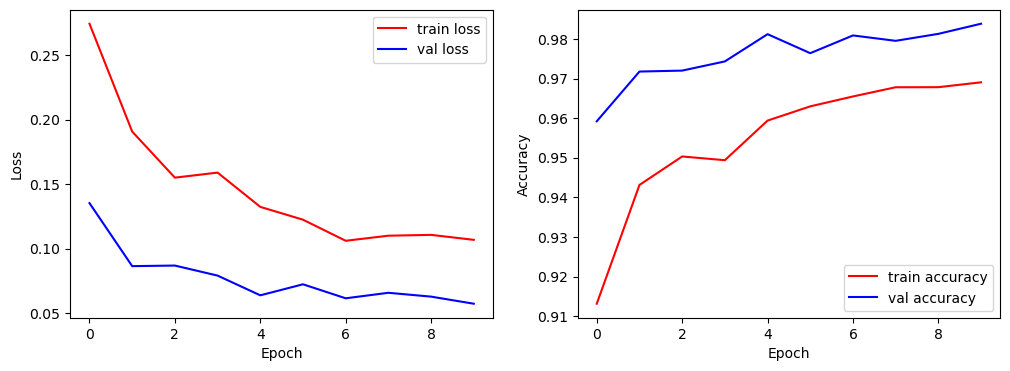

In [11]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
ax[0].plot(history.history["loss"], c="r", label="train loss")
ax[0].plot(history.history["val_loss"], c="b", label="val loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], c="r", label="train accuracy")
ax[1].plot(history.history["val_accuracy"], c="b", label="val accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

# **Confusion matrix**

In [12]:
# Predict the values from the validation dataset
y_pred = model.predict(test_data)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(test_label,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

313/313 [==============================] - 102s 327ms/step


[[Text(0.5, 0, 'plane'),
  Text(1.5, 0, 'car'),
  Text(2.5, 0, 'bird'),
  Text(3.5, 0, 'cat'),
  Text(4.5, 0, 'deer'),
  Text(5.5, 0, 'dog'),
  Text(6.5, 0, 'frog'),
  Text(7.5, 0, 'horse'),
  Text(8.5, 0, 'ship'),
  Text(9.5, 0, 'truck')],
 [Text(0, 0.5, 'plane'),
  Text(0, 1.5, 'car'),
  Text(0, 2.5, 'bird'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'frog'),
  Text(0, 7.5, 'horse'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')]]

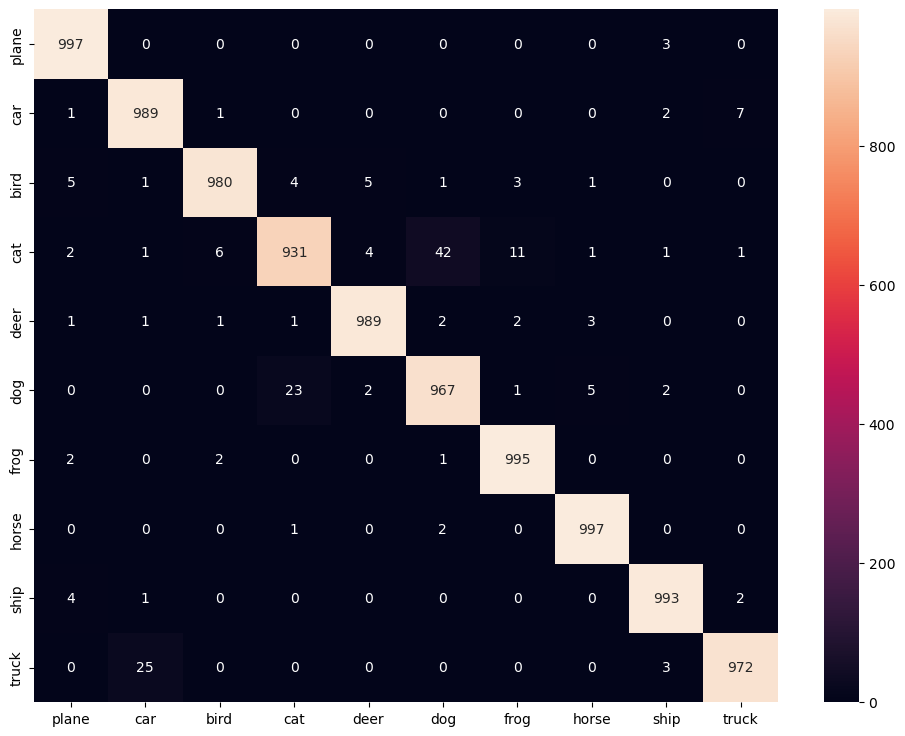

In [13]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plt.figure(figsize=(12, 9))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
c.set(xticklabels=classes, yticklabels=classes)

# Submission

In [14]:
y_pred=model.predict(test_data)
y_true=np.argmax(y_pred,axis=1)
y_true= pd.Series(y_true,name="Label")

313/313 [==============================] - 102s 327ms/step


In [15]:
submission = pd.concat([pd.Series(range(0,10000),name = "ID"),y_true],axis = 1)

submission.to_csv("solution.csv",index=False)